In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random as rdm
import os
np.random.seed(0)
import seaborn as sns
from scipy.optimize import linprog

In [2]:
#problem(1)
Rfunc1 = np.zeros((10,10))
Rfunc1[-1][-1] = 1.0
Rfunc2 = np.zeros((10, 10))
Rfunc2[1:7,4] = -100.0
Rfunc2[1,5] = -100.0
Rfunc2[1:4,6] = Rfunc2[7:9,6] = -100.0
Rfunc2[3,7] = Rfunc2[7,7] = -100.0
Rfunc2[3:8,8] = -100.0
Rfunc2[-1][-1] = 10.0

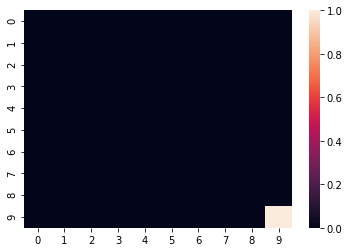

In [3]:
hm1 = sns.heatmap(Rfunc1)

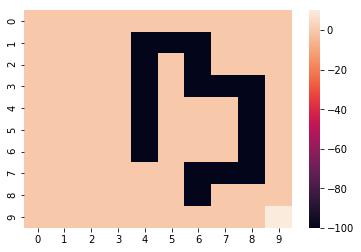

In [4]:
hm2 = sns.heatmap(Rfunc2)

In [5]:
#problem2
width = 10
height = 10
tp = np.zeros((height * width, 5, 4)) # third dimension is direction, last denotes action
#direction to next state 0 : up 1 : right 2 : down 3 : left 4: stay
#action 0 : up 1 : right 2 : down 3 : left
w = 0.1
dx = [0, 1, 0, -1, 0]
dy = [-1, 0, 1, 0, 0]

In [6]:
def isCorner(x, y, height, width):
    return (((y == height - 1) or (y == 0)) and ((x == width - 1) or (x == 0)))
def isEdge(x, y, height, width):
    return (x == 0) or (x == height - 1) or (y == 0) or(y == width - 1)
def offGrid(x, y, height, width):
    return (x < 0) or (x >= height) or (y < 0) or(y >= width)

In [7]:
def cornerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w / 2.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 2.0
            
def edgeSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): #action
        if(offGrid(x + dx[i], y + dy[i], height, width)):
            for j in range(4):
                if not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = 1 - w + w / 4.0
        else:
            for j in range(4):
                if i == j:
                    tp[state][j][i] = 1 - w + w / 4.0
                elif not offGrid(x + dx[j], y + dy[j], height, width):
                    tp[state][j][i] = w / 4.0
            tp[state][4][i] = w / 4.0   
            
def innerSol(x, y, tp, height, width, w):
    state = x * height + y
    for i in range(4): # atcion
        for j in range(4):
            if i == j:
                tp[state][j][i] = 1 - w + w / 4.0
            else:
                tp[state][j][i] = w / 4.0

In [8]:
w = 0.1
for i in range(height * width): #calculate transition prob
    x = i // height
    y = i % height
    if isCorner(x, y, height, width):
        cornerSol(x, y, tp, height, width, w)
    elif isEdge(x, y, height, width):
        edgeSol(x, y, tp, height, width, w)
    else:
        innerSol(x, y, tp, height, width, w)

In [9]:
def calStateValue(state, tp, Rfunc, Vs, discount):
    value = np.zeros(4)
    x = state // height
    y = state % height
    for action in range(4):
        for i in range(5):
            x1 = x + dx[i]
            y1 = y + dy[i]
            if offGrid(x1, y1, height, width):
                continue
            state1 = x1 * height + y1
            value[action] += tp[state][i][action] * (Rfunc[y1][x1] + discount * Vs[state1])
    return value
def calVs(Vs, tp, Rfunc, discount, theta):
    while True:
        delta = 0.0
        for s in range(width * height):
            actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
            maxActionValue = max(actionValue)
            delta = max(np.abs(maxActionValue - Vs[s]), delta)
            Vs[s] = maxActionValue
        if delta < theta:
            break

In [10]:
Vs1 = np.zeros(height * width)
discount = 0.8
theta = 0.01
calVs(Vs1, tp, Rfunc1, discount, theta)#calculate state value for each state

In [11]:
from tabulate import tabulate

In [12]:
Vs1_2d = Vs1.reshape((height, width))
print(tabulate(Vs1_2d.T,  tablefmt='fancy_grid'))

╒═══════════╤═══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ 0.0417957 │ 0.0628379 │ 0.089742 │ 0.123849 │ 0.167081 │ 0.221883 │ 0.291354 │ 0.37942  │ 0.490983 │ 0.609648 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.0628379 │ 0.0878701 │ 0.121557 │ 0.164514 │ 0.219246 │ 0.28899  │ 0.377871 │ 0.491061 │ 0.633219 │ 0.787354 │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.089742  │ 0.121557  │ 0.16439  │ 0.219132 │ 0.288903 │ 0.377826 │ 0.491156 │ 0.63549  │ 0.817355 │ 1.0186   │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 0.123849  │ 0.164514  │ 0.219132 │ 0.2889   │ 0.377825 │ 0.491159 │ 0.635601 │ 0.81961  │ 1.05219  │ 1.31506  │
├───────────┼───────────┼──────────┼──────────┼──────────┼──────────┼──────────┼────────

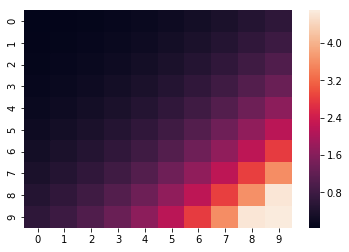

In [13]:
#problem3
hm3 = sns.heatmap(Vs1_2d.T)

In [14]:
#problem5
arrows = ['↑','→','↓','←']
def calOptimalAction(optimalAction, tp, Rfunc, Vs, discount):
    for s in range(height * width):
        actionValue = calStateValue(s, tp, Rfunc, Vs, discount)
        optimal = np.argmax(actionValue)
        optimalAction[s] = optimal
def action2Arrow(action, arrows):
    return [arrows[int(i)] for i in action]

In [15]:
optimalAction1 = np.zeros(height * width)
calOptimalAction(optimalAction1, tp, Rfunc1, Vs1, discount)

In [16]:
optimalAction1_2d = optimalAction1.reshape((height, width))
arrows1 = action2Arrow(optimalAction1, arrows)
path1 = np.array(arrows1).reshape((height,width)).T
print(tabulate(optimalAction1_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [17]:
print(tabulate(path1))

-  -  -  -  -  -  -  -  -  -
↓  →  →  →  →  →  →  ↓  ↓  ↓
↓  →  →  →  →  →  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  ↓  →  ↓  ↓  ↓  ↓  ↓  ↓
↓  ↓  →  →  →  →  ↓  ↓  ↓  ↓
↓  →  →  →  →  →  →  ↓  ↓  ↓
→  →  →  →  →  →  →  →  ↓  ↓
→  →  →  →  →  →  →  →  →  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


# IRL #

In [18]:
def tp2tpm(height, width, tp):
    tpm = np.zeros((height * width, 4, height * width))
    for s in range(tp.shape[0]):
        x = s // height
        y = s % height
        for action in range(tp.shape[2]):
            for i in range(tp.shape[1]):
                x1 = x + dx[i]
                y1 = y + dy[i]
                if not offGrid(x1, y1, height, width):
                    s1 = x1 * height + y1
                    tpm[s][action][s1] = tp[s][i][action]
    return tpm

In [19]:
def calculate_LP_D(a, s, policy, gamma, tp):
    # (Pa1 −Pa)(I−γPa1)−1
    return np.dot(tp[int(policy[s]), s] - tp[a, s], np.linalg.inv(np.eye(100) - gamma*tp[int(policy[s])]))

In [20]:
def calculate_accuracy(n_states, ground_truth, extracted_reward):
    count = 0
    for i in range(n_states):
        if ground_truth[i] == round(extracted_reward[i]):
            count += 1
    return float(count)/float(n_states)

In [38]:
#Setting b to be rmax a
import numpy as np
from cvxopt import solvers,matrix
lamda_list = np.linspace(0,5,100)
A = {0,1,2,3}
n_actions = 4
n_states = 100
gamma = 0.8
tpm = tp2tpm(height, width, tp)
print(tpm.shape)
transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
Rmax = Rfunc1.max()
def perform_IRL(optimalAction, transition_probability, Rmax):
    for lamda in lamda_list:
        n_states = 100
        policy = optimalAction
        C = -np.hstack([np.zeros(100), np.ones(100), -lamda*np.ones(100)]) 
#         print(C.shape)   
#         print(A - {policy[1]})
        T_stack = np.vstack([
                calculate_LP_D(a, s, policy, gamma, transition_probability)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        one_stack = np.vstack([
                np.eye(1, n_states, s)
                for s in range(n_states)
                for a in A - {policy[s]}
            ])
        # X = [R, T, U, M]
        # (Pa1 −Pa)(I−γPa1)−1 * R >= T => -(Pa1 −Pa)(I−γPa1)−1 * R <= -T => -(Pa1 −Pa)(I−γPa1)−1 * R + T <= 0
        D_0 = np.hstack([-T_stack, one_stack,np.zeros((300,100))])
        # (Pa1 −Pa)(I−γPa1)−1 * R >= 0 => -(Pa1 −Pa)(I−γPa1)−1 * R <= 0
        D_1 = np.hstack([-T_stack, np.zeros((300,100)),np.zeros((300,100))])
        # R <= u and R >= -u => R-u<=0 and -R-u <=0
        D_2 = np.hstack([np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        D_3 = np.hstack([-np.eye(n_states),np.zeros((100,100)),-np.eye(n_states)])
        # R <= Rmax and R >= -Rmax => R - Rmax <=0 and -R - Rmax <=0
        D_4 = np.hstack([np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])
        D_5 = np.hstack([-np.eye(n_states), np.zeros((100,100)), np.zeros((100,100))])

        D = np.vstack([D_0, D_1, D_2, D_3, D_4, D_5])        
#         print(D)
        d = matrix(D)
#         B = np.zeros((1000))
        B = np.zeros((800, 1))  
#         print(B.shape)
        b_bounds = np.vstack([Rmax*np.ones((n_states, 1)), Rmax*np.ones((n_states, 1))])
#         print(b_bounds.shape)  
        B = np.vstack((B, b_bounds))
#         print(B.shape)
#         print(B.shape)
#         print(D.shape)
#         print(C.shape)
        b = matrix(B)
        c = matrix(C)
        results = solvers.lp(c, d, b)
        r = np.asarray(results["x"][:n_states], dtype=np.double)
        # print(r)
        r = r.reshape((n_states,))
#         print((r.reshape((n_states,)))[99])
#         if calculate_accuracy(100, optimalAction, r) > 0:
        print(calculate_accuracy(100, optimalAction, r))
    

(100, 4, 100)


In [39]:
perform_IRL(optimalAction1, transition_probability, Rmax)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.1131e+01 -1.0568e+02  4e+02  7e-01  5e+00  1e+00
 2: -2.0338e+01 -7.9226e+01  3e+02  5e-01  3e+00  7e-01
 3: -3.0467e+01 -5.9163e+01  1e+02  2e-01  2e+00  3e-01
 4: -3.6246e+01 -4.7375e+01  5e+01  9e-02  6e-01  1e-01
 5: -3.8451e+01 -4.4914e+01  3e+01  5e-02  4e-01  6e-02
 6: -3.9938e+01 -4.2943e+01  1e+01  2e-02  2e-01  3e-02
 7: -4.1140e+01 -4.2248e+01  5e+00  9e-03  6e-02  6e-03
 8: -4.1676e+01 -4.2245e+01  2e+00  4e-03  3e-02  3e-03
 9: -4.2008e+01 -4.2214e+01  9e-01  2e-03  1e-02  1e-03
10: -4.1997e+01 -4.2183e+01  8e-01  1e-03  1e-02  9e-04
11: -4.2097e+01 -4.2143e+01  2e-01  4e-04  3e-03  2e-04
12: -4.2109e+01 -4.2138e+01  1e-01  2e-04  2e-03  1e-04
13: -4.2122e+01 -4.2132e+01  4e-02  8e-05  5e-04  4e-05
14: -4.2124e+01 -4.2130e+01  3e-02  5e-05  3e-04  3e-05
15: -4.2125e+01 -4.2129e+01  2e-02  3e-05  2e-04  2e-05
16: -4.2124e+01 -4.2128e+01  2e-02  3e-05  2e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1: -2.2615e+00 -7.7550e+01  3e+02  6e-01  4e+00  1e+00
 2: -7.0157e+00 -5.3751e+01  2e+02  4e-01  2e+00  7e-01
 3: -1.1719e+01 -3.7258e+01  1e+02  2e-01  1e+00  3e-01
 4: -1.5814e+01 -2.8047e+01  5e+01  1e-01  6e-01  1e-01
 5: -1.7987e+01 -2.2634e+01  2e+01  4e-02  2e-01  3e-02
 6: -1.9032e+01 -2.1468e+01  9e+00  2e-02  1e-01  1e-02
 7: -1.9890e+01 -2.0613e+01  3e+00  6e-03  4e-02  4e-03
 8: -2.0170e+01 -2.0515e+01  1e+00  3e-03  2e-02  2e-03
 9: -2.0246e+01 -2.0460e+01  8e-01  2e-03  1e-02  9e-04
10: -2.0330e+01 -2.0424e+01  3e-01  7e-04  5e-03  4e-04
11: -2.0356e+01 -2.0409e+01  2e-01  4e-04  3e-03  2e-04
12: -2.0367e+01 -2.0400e+01  1e-01  3e-04  2e-03  1e-04
13: -2.0376e+01 -2.0391e+01  6e-02  1e-04  8e-04  6e-05
14: -2.0381e+01 -2.0387e+01  2e-02  5e-05  3e-04  2e-05
15: -2.0383e+01 -2.0384e+01  4e-03  8e-06  5e-05  4e-06
16: -2.0384e+01 -2.0384e+01  2e-03  3e-06  2e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.2826e+00 -5.6504e+01  2e+02  5e-01  3e+00  1e+00
 2:  2.6967e-01 -3.0621e+01  1e+02  2e-01  1e+00  5e-01
 3: -1.6408e-01 -1.5529e+01  5e+01  1e-01  7e-01  2e-01
 4: -1.4845e+00 -6.7636e+00  1e+01  4e-02  2e-01  7e-02
 5: -1.9119e+00 -5.1188e+00  9e+00  3e-02  1e-01  4e-02
 6: -2.4349e+00 -3.4539e+00  3e+00  8e-03  5e-02  1e-02
 7: -2.5715e+00 -3.0898e+00  1e+00  4e-03  2e-02  3e-03
 8: -2.6183e+00 -2.8758e+00  7e-01  2e-03  1e-02  1e-03
 9: -2.6745e+00 -2.7753e+00  3e-01  8e-04  5e-03  4e-04
10: -2.6963e+00 -2.7233e+00  7e-02  2e-04  1e-03  7e-05
11: -2.7016e+00 -2.7063e+00  1e-02  4e-05  2e-04  1e-05
12: -2.7023e+00 -2.7034e+00  3e-03  9e-06  5e-05  3e-06
13: -2.7024e+00 -2.7027e+00  6e-04  2e-06  1e-05  6e-07
14: -2.7025e+00 -2.7025e+00  2e-04  5e-07  3e-06  2e-07
15: -2.7025e+00 -2.7025e+00  6e-05  2e-07  1e-06  6e-08
16: -2.7025e+00 -2.7025e+00  1e-05  3e-08  2e-07  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.5309e+00 -6.1209e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.0261e+00 -1.9377e+01  6e+01  2e-01  8e-01  4e-01
 3:  2.3655e+00 -3.9552e+00  1e+01  5e-02  2e-01  5e-02
 4:  2.7894e-01 -2.6331e-01  1e+00  4e-03  2e-02  3e-03
 5:  3.0312e-03 -2.8714e-03  1e-02  5e-05  2e-04  3e-05
 6:  3.0304e-05 -2.8707e-05  1e-04  5e-07  2e-06  3e-07
 7:  3.0304e-07 -2.8707e-07  1e-06  5e-09  2e-08  3e-09
 8:  3.0304e-09 -2.8707e-09  1e-08  5e-11  2e-10  3e-11
Optimal solution found.
0.0
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.6505e+00 -6.1160e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.1392e+00 -1.8251e+01  6e+01  2e-01  7e-01  4e-01
 3:  2.2019e+00 -3.2194e+00  1e+01  4e-02  2e-01  4e-02
 4:  1.8268e-01 -1.6695e-01  7e-01  3e-03  1e-02  2e-03
 5:  1.8697e-03 -1.7190e-03  7e-03  3e-05  1e-04  2e-05
 6:  1.8695e-05 -1.7187e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.7779e+00 -6.7388e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7841e+00 -1.5958e+01  6e+01  2e-01  5e-01  3e-01
 3:  7.7942e-01 -1.1619e+00  5e+00  2e-02  5e-02  2e-02
 4:  1.0205e-02 -1.4308e-02  6e-02  2e-04  6e-04  2e-04
 5:  1.0201e-04 -1.4302e-04  6e-04  2e-06  6e-06  2e-06
 6:  1.0201e-06 -1.4302e-06  6e-06  2e-08  6e-08  2e-08
 7:  1.0201e-08 -1.4302e-08  6e-08  2e-10  6e-10  2e-10
Optimal solution found.
0.0
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.9556e+00 -6.7345e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7843e+00 -1.5070e+01  6e+01  1e-01  5e-01  3e-01
 3:  6.9508e-01 -9.7261e-01  4e+00  1e-02  4e-02  1e-02
 4:  8.4025e-03 -1.1449e-02  5e-02  2e-04  5e-04  1e-04
 5:  8.3995e-05 -1.1445e-04  5e-04  2e-06  5e-06  1e-06
 6:  8.3995e-07 -1.1445e-06  5e-06  2e-08  5e-08  1e-08
 7:  8.3995e-09 -1.1445e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.4239e+00 -6.2594e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.5324e+00 -1.0321e+01  4e+01  1e-01  3e-01  2e-01
 3:  3.2841e-01 -6.1839e-01  3e+00  7e-03  2e-02  6e-03
 4:  3.3386e-03 -6.2781e-03  3e-02  8e-05  2e-04  6e-05
 5:  3.3382e-05 -6.2774e-05  3e-04  8e-07  2e-06  6e-07
 6:  3.3382e-07 -6.2774e-07  3e-06  8e-09  2e-08  6e-09
 7:  3.3382e-09 -6.2774e-09  3e-08  8e-11  2e-10  6e-11
Optimal solution found.
0.0
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.5610e+00 -6.2101e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.5020e+00 -1.0193e+01  4e+01  1e-01  2e-01  2e-01
 3:  3.1263e-01 -5.9724e-01  3e+00  7e-03  2e-02  6e-03
 4:  3.1704e-03 -6.0500e-03  3e-02  7e-05  2e-04  6e-05
 5:  3.1701e-05 -6.0493e-05  3e-04  7e-07  2e-06  6e-07
 6:  3.1701e-07 -6.0493e-07  3e-06  7e-09  2e-08  6e-09
 7:  3.1701e-09 -6.0493e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0391e+00 -5.3677e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.7725e+00 -8.0330e+00  4e+01  9e-02  2e-01  1e-01
 3:  1.4468e-01 -3.5577e-01  2e+00  4e-03  7e-03  4e-03
 4:  1.4465e-03 -3.5556e-03  2e-02  4e-05  7e-05  4e-05
 5:  1.4464e-05 -3.5554e-05  2e-04  4e-07  7e-07  4e-07
 6:  1.4464e-07 -3.5554e-07  2e-06  4e-09  7e-09  4e-09
 7:  1.4464e-09 -3.5554e-09  2e-08  4e-11  7e-11  4e-11
Optimal solution found.
0.0
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0985e+00 -5.3081e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.7068e+00 -7.8826e+00  4e+01  8e-02  2e-01  1e-01
 3:  1.3542e-01 -3.3795e-01  1e+00  4e-03  7e-03  3e-03
 4:  1.3536e-03 -3.3768e-03  1e-02  4e-05  7e-05  3e-05
 5:  1.3535e-05 -3.3767e-05  1e-04  4e-07  7e-07  3e-07
 6:  1.3535e-07 -3.3767e-07  1e-06  4e-09  7e-09  3e-09
 7:  1.3535e-09 -3.3767e

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.5508e+00 -4.5549e+01  3e+02  4e-01  7e-01  5e-01
 2:  1.7943e+00 -6.7143e+00  3e+01  7e-02  1e-01  9e-02
 3:  5.2110e-02 -1.6551e-01  7e-01  2e-03  3e-03  2e-03
 4:  5.2054e-04 -1.6531e-03  7e-03  2e-05  3e-05  2e-05
 5:  5.2053e-06 -1.6531e-05  7e-05  2e-07  3e-07  2e-07
 6:  5.2053e-08 -1.6531e-07  7e-07  2e-09  3e-09  2e-09
 7:  5.2053e-10 -1.6531e-09  7e-09  2e-11  3e-11  2e-11
Optimal solution found.
0.0
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8479e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.5530e+00 -4.5119e+01  3e+02  4e-01  7e-01  5e-01
 2:  1.7325e+00 -6.6657e+00  3e+01  7e-02  1e-01  9e-02
 3:  4.8633e-02 -1.5735e-01  7e-01  2e-03  2e-03  2e-03
 4:  4.8582e-04 -1.5717e-03  7e-03  2e-05  2e-05  2e-05
 5:  4.8581e-06 -1.5717e-05  7e-05  2e-07  2e-07  2e-07
 6:  4.8581e-08 -1.5717e-07  7e-07  2e-09  2e-09  2e-09
 7:  4.8581e-10 -1.5717e

In [23]:
#problem6
Vs2 = np.zeros(height * width)
calVs(Vs2, tp, Rfunc2, discount, theta)#calculate state value for each state

In [24]:
Vs2_2d = Vs2.reshape((height, width))
print(tabulate(Vs2_2d.T,  tablefmt='fancy_grid'))

╒══════════╤══════════╤══════════╤════════════╤══════════╤════════════╤═══════════╤══════════╤═══════════╤══════════╕
│ 0.648477 │ 0.794107 │ 0.825238 │  0.536246  │ -2.37043 │  -4.23382  │ -1.92053  │  1.13111 │  1.59436  │  2.03821 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 0.829852 │ 1.02124  │ 1.06603  │ -1.8679    │ -6.73822 │  -8.67375  │ -6.36979  │ -1.2948  │  1.92834  │  2.61047 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.06361  │ 1.31651  │ 1.45008  │ -1.62403   │ -6.74151 │ -13.9112   │ -9.64923  │ -5.51104 │ -0.131013 │  3.35906 │
├──────────┼──────────┼──────────┼────────────┼──────────┼────────────┼───────────┼──────────┼───────────┼──────────┤
│ 1.36025  │ 1.6927   │ 1.94802  │ -1.23217   │ -6.32308 │  -7.97761  │ -7.93668  │ -9.42387 │ -1.91443  │  4.39063 │
├──────────┼──────────┼──────────┼────────────┼─────────

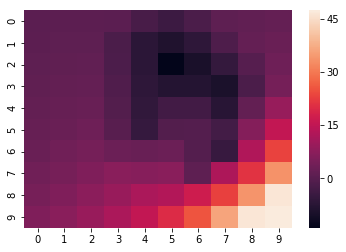

In [25]:
#problem7
hm4 = sns.heatmap(Vs2_2d.T)

In [26]:
#problem9
optimalAction2 = np.zeros(height * width)
calOptimalAction(optimalAction2, tp, Rfunc2, Vs2, discount)

In [27]:
optimalAction2_2d = optimalAction2.reshape((height, width))
arrows2 = action2Arrow(optimalAction2, arrows)
path2 = np.array(arrows2).reshape((height,width)).T
print(tabulate(optimalAction2_2d.T,  tablefmt='fancy_grid'))

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 0 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 1 │ 1 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 0 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 2 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 3 │ 3 │ 2 │ 2 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 3 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │ 1 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛


In [28]:
print(tabulate(path2))

-  -  -  -  -  -  -  -  -  -
↓  ↓  ↓  ←  ←  →  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↑  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  →  →  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↑  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ↓  →  ↓
↓  ↓  ↓  ←  ←  ↓  ↓  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ←  →  ↓
↓  ↓  ↓  ↓  ↓  ↓  ←  ↓  ↓  ↓
→  →  →  ↓  ↓  ↓  ↓  ↓  ↓  ↓
→  →  →  →  →  →  →  →  →  →
-  -  -  -  -  -  -  -  -  -


In [40]:
# tpm = tp2tpm(height, width, tp)
# print(tpm.shape)
# transition_probability = np.transpose(tpm, (1, 0, 2))
# print(transition_probability)
Rmax = Rfunc2.max()
perform_IRL(optimalAction2, transition_probability, Rmax)


     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.2585e+00 -1.1221e+03  2e+03  9e-02  8e+00  8e-01
 2: -3.4423e+01 -6.8431e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.3348e+02 -4.7421e+02  8e+02  3e-02  2e+00  6e-01
 4: -2.6412e+02 -5.5468e+02  9e+02  2e-02  2e+00  6e-01
 5: -3.3301e+02 -5.6734e+02  9e+02  2e-02  2e+00  6e-01
 6: -4.3662e+02 -5.6416e+02  6e+02  1e-02  9e-01  4e-01
 7: -4.5898e+02 -5.4369e+02  4e+02  7e-03  6e-01  3e-01
 8: -5.0518e+02 -5.4344e+02  2e+02  3e-03  3e-01  2e-01
 9: -5.2242e+02 -5.4582e+02  1e+02  2e-03  2e-01  1e-01
10: -5.3535e+02 -5.4714e+02  6e+01  9e-04  8e-02  6e-02
11: -5.4424e+02 -5.4961e+02  3e+01  4e-04  4e-02  3e-02
12: -5.5033e+02 -5.5154e+02  6e+00  1e-04  9e-03  6e-03
13: -5.5066e+02 -5.5159e+02  5e+00  8e-05  7e-03  5e-03
14: -5.5129e+02 -5.5174e+02  2e+00  4e-05  3e-03  2e-03
15: -5.5182e+02 -5.5188e+02  3e-01  5e-06  4e-04  3e-04
16: -5.5188e+02 -5.5190e+02  8e-02  1e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.0837e+01 -1.0154e+03  2e+03  8e-02  7e+00  7e-01
 2:  1.5723e+01 -5.9236e+02  1e+03  5e-02  4e+00  6e-01
 3: -3.0502e+01 -2.7992e+02  4e+02  2e-02  2e+00  4e-01
 4: -9.5762e+01 -3.2096e+02  6e+02  2e-02  2e+00  4e-01
 5: -1.3737e+02 -3.3300e+02  6e+02  2e-02  1e+00  4e-01
 6: -1.8008e+02 -3.2677e+02  5e+02  1e-02  1e+00  3e-01
 7: -2.2728e+02 -3.1573e+02  3e+02  7e-03  6e-01  2e-01
 8: -2.4613e+02 -3.0947e+02  2e+02  5e-03  4e-01  2e-01
 9: -2.8026e+02 -3.0704e+02  1e+02  2e-03  2e-01  8e-02
10: -2.9485e+02 -3.0706e+02  5e+01  1e-03  8e-02  4e-02
11: -3.0387e+02 -3.0707e+02  1e+01  3e-04  2e-02  1e-02
12: -3.0623e+02 -3.0733e+02  4e+00  9e-05  8e-03  4e-03
13: -3.0711e+02 -3.0746e+02  1e+00  3e-05  2e-03  1e-03
14: -3.0747e+02 -3.0754e+02  3e-01  6e-06  5e-04  3e-04
15: -3.0753e+02 -3.0755e+02  9e-02  2e-06  1e-04  8e-05
16: -3.0755e+02 -3.0755e+02  7e-03  1e-07  1e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.7189e+01 -1.0024e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.1356e+01 -5.6767e+02  9e+02  5e-02  4e+00  6e-01
 3:  1.2197e+01 -2.2538e+02  4e+02  2e-02  1e+00  3e-01
 4: -2.9234e+00 -1.6705e+02  3e+02  1e-02  1e+00  2e-01
 5: -4.3097e+01 -1.3424e+02  2e+02  7e-03  5e-01  2e-01
 6: -4.4212e+01 -1.3371e+02  2e+02  7e-03  5e-01  2e-01
 7: -6.2711e+01 -1.3501e+02  2e+02  6e-03  4e-01  2e-01
 8: -7.2307e+01 -1.2538e+02  2e+02  4e-03  3e-01  1e-01
 9: -8.9644e+01 -1.1960e+02  1e+02  2e-03  2e-01  8e-02
10: -1.0523e+02 -1.1754e+02  4e+01  1e-03  7e-02  4e-02
11: -1.1124e+02 -1.1791e+02  2e+01  5e-04  4e-02  2e-02
12: -1.1167e+02 -1.1771e+02  2e+01  5e-04  4e-02  2e-02
13: -1.1437e+02 -1.1782e+02  1e+01  3e-04  2e-02  1e-02
14: -1.1672e+02 -1.1795e+02  4e+00  1e-04  7e-03  4e-03
15: -1.1734e+02 -1.1798e+02  2e+00  5e-05  4e-03  2e-03
16: -1.1776e+02 -1.1801e+02  9e-01  2e-05  2e-03  

20: -9.9158e+00 -9.9280e+00  3e-02  1e-06  6e-05  3e-05
21: -9.9214e+00 -9.9260e+00  1e-02  4e-07  2e-05  1e-05
22: -9.9242e+00 -9.9248e+00  1e-03  4e-08  3e-06  1e-06
23: -9.9246e+00 -9.9246e+00  2e-05  7e-10  5e-08  2e-08
24: -9.9246e+00 -9.9246e+00  5e-06  1e-10  9e-09  5e-09
Optimal solution found.
0.03
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.7047e+01 -9.9710e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.8637e+01 -5.6914e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.0307e+01 -1.7546e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.4934e+01 -4.5443e+01  9e+01  5e-03  3e-01  8e-02
 5:  1.0090e+01 -2.3549e+01  5e+01  3e-03  2e-01  5e-02
 6:  3.5034e+00 -5.8728e+00  1e+01  8e-04  5e-02  1e-02
 7:  1.5329e+00 -2.2577e+00  6e+00  3e-04  2e-02  6e-03
 8:  1.0040e+00 -9.8932e-01  3e+00  2e-04  1e-02  3e-03
 9:  3.7623e-01 -1.7458e-01  8e-01  4e-05  3e-03  9e-04
10:  7.1489e-02 -1.9196e-02  1e-01  7e-06  4e-04  9e-05
11:  2.5018e-03 -6.75

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.5651e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.7814e+01 -5.6958e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.0830e+01 -1.5142e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.4109e+01 -1.4328e+01  3e+01  2e-03  1e-01  3e-02
 5:  5.2331e-01 -2.3473e-01  9e-01  6e-05  3e-03  8e-04
 6:  5.2261e-03 -2.3442e-03  9e-03  6e-07  3e-05  8e-06
 7:  5.2260e-05 -2.3441e-05  9e-05  6e-09  3e-07  8e-08
 8:  5.2260e-07 -2.3441e-07  9e-07  6e-11  3e-09  8e-10
 9:  5.2260e-09 -2.3441e-09  9e-09  6e-13  3e-11  8e-12
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.6068e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.9012e+01 -5.6916e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.2049e+01 -1.5041e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.3555e+01 -1.2500e+01  3e+01  2e-03  9e-02  3e-02
 5:  3.9615e-01 -1.7268

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8955e+01 -9.9559e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.0535e+01 -5.5983e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.2913e+01 -1.3566e+02  3e+02  2e-02  6e-01  2e-01
 4:  9.6893e+00 -8.4258e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.1986e-01 -8.9120e-02  2e-01  2e-05  6e-04  2e-04
 6:  1.1981e-03 -8.9087e-04  2e-03  2e-07  6e-06  2e-06
 7:  1.1981e-05 -8.9086e-06  2e-05  2e-09  6e-08  2e-08
 8:  1.1981e-07 -8.9086e-08  2e-07  2e-11  6e-10  2e-10
 9:  1.1981e-09 -8.9086e-10  2e-09  2e-13  6e-12  2e-12
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9063e+01 -9.9571e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.1313e+01 -5.5874e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.3579e+01 -1.3428e+02  3e+02  2e-02  6e-01  3e-01
 4:  9.3410e+00 -8.1527e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.1186e-01 -8.5575

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9391e+01 -9.9711e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9222e+01 -5.4281e+02  1e+03  5e-02  1e+00  6e-01
 3:  6.9796e+01 -1.1877e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.5029e+00 -3.2400e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.5853e-02 -3.2974e-02  1e-01  7e-06  2e-04  1e-04
 6:  5.5845e-04 -3.2970e-04  1e-03  7e-08  2e-06  1e-06
 7:  5.5845e-06 -3.2970e-06  1e-05  7e-10  2e-08  1e-08
 8:  5.5845e-08 -3.2970e-08  1e-07  7e-12  2e-10  1e-10
 9:  5.5845e-10 -3.2970e-10  1e-09  7e-14  2e-12  1e-12
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9357e+01 -9.9721e+02  2e+03  9e-02  2e+00  6e-01
 2:  9.9786e+01 -5.4130e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.0239e+01 -1.1824e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.3115e+00 -3.0364e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.3781e-02 -3.0849

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8424e+01 -9.9803e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0617e+02 -5.1994e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4359e+01 -1.0549e+02  3e+02  1e-02  3e-01  3e-01
 4:  4.0913e+00 -2.7695e+00  9e+00  5e-04  1e-02  9e-03
 5:  4.1120e-02 -2.7865e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.1117e-04 -2.7862e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.1117e-06 -2.7862e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.1117e-08 -2.7862e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8325e+01 -9.9805e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0661e+02 -5.1821e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4572e+01 -1.0413e+02  3e+02  1e-02  3e-01  3e-01
 4:  3.9916e+00 -2.7312e+00  8e+00  5e-04  1e-02  9e-03
 5:  4.0093e-02 -2.7460e-02  8e-02  5e-06  1e-04  9e-05
 6:  4.0090e-04 -2.7458

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6830e+01 -9.9777e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0978e+02 -5.1546e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3968e+01 -9.6654e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.4947e+00 -2.3745e+00  8e+00  5e-04  9e-03  9e-03
 5:  3.4928e-02 -2.3749e-02  8e-02  5e-06  9e-05  9e-05
 6:  3.4927e-04 -2.3748e-04  8e-04  5e-08  9e-07  9e-07
 7:  3.4927e-06 -2.3748e-06  8e-06  5e-10  9e-09  9e-09
 8:  3.4927e-08 -2.3748e-08  8e-08  5e-12  9e-11  9e-11
Optimal solution found.
0.02
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6705e+01 -9.9770e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0992e+02 -5.1575e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3859e+01 -9.7544e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.2826e+00 -2.2837e+00  7e+00  4e-04  9e-03  8e-03
 5:  3.2798e-02 -2.2832e-02  7e-02  4e-06  9e-05  8e-05
 6:  3.2796e-04 -2.2831

In [30]:
a = np.array((1,2,3))
b = np.array((2,3,4))
np.hstack((a,b))

array([1, 2, 3, 2, 3, 4])

In [31]:
np.hstack([a,b])

array([1, 2, 3, 2, 3, 4])